This botebook is aboit getting your own data into pytorch. One of the ways to do so is to build custom Datasets.

For each and any problem read the doc fot the specific Dataset class (vision, text, audio, etc) and implement your own.

# Section 0: Imports

In [41]:
# torch
import torch
from torch import nn
import torch.nn.functional as F
import torchvision
from torchvision import transforms, datasets

# visualisation
import matplotlib.pyplot as plt
from PIL import Image

# nav : 
from pathlib import Path

# utils
from pathlib import Path
import requests
import zipfile

In [3]:
device = torch.device("mps")

# Section 1: Create the Dataset

Inspired by food101, we will use a subset for our experiences.

In the notebook extra > custom_dataset

We start with 3 classes of food, and start with only 10% of the images. Starting ML projects, it is indeed important to experiment small and fast and then scale up.

In [5]:
data_path = Path("data")
img_path = data_path / "pizza_steak_sushi"



if img_path.is_dir():
    print("data already downloaded")

else:
    print("image path doesn't exist, creating one.")
    img_path.mkdir(parents=True, exist_ok=True)

    with open(data_path / "pizza_steak_sushi.zip", "wb") as f:
        request =  requests.get("https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip")
        print("downloading data")
        f.write(request.content)


    with zipfile.ZipFile(data_path / "pizza_steak_sushi.zip", "r") as zip_ref:
        print("unzipping file")
        zip_ref.extractall(img_path)

data already downloaded


In [6]:
train_path = img_path / "train"
test_path = img_path / "test"

### Visualize the datain the dataset:

In [13]:
import matplotlib.pyplot as plt
import random
from PIL import Image
import os

def walkthrough(dir_path):
    """ walks through dirpath and return its content"""

    for dirpath, dirnames, filenames in os.walk(dir_path):
        print(f"there are {len(dirnames)} directories and {len(filenames)} files in {dirpath}.")

In [11]:
walkthrough(img_path)

there are 2 directories and 0 files in data/pizza_steak_sushi.
there are 3 directories and 0 files in data/pizza_steak_sushi/test.
there are 0 directories and 19 files in data/pizza_steak_sushi/test/steak.
there are 0 directories and 31 files in data/pizza_steak_sushi/test/sushi.
there are 0 directories and 25 files in data/pizza_steak_sushi/test/pizza.
there are 3 directories and 0 files in data/pizza_steak_sushi/train.
there are 0 directories and 75 files in data/pizza_steak_sushi/train/steak.
there are 0 directories and 72 files in data/pizza_steak_sushi/train/sushi.
there are 0 directories and 78 files in data/pizza_steak_sushi/train/pizza.


In [37]:
def display_img(path):
    img = Image.open(path)
    print("size :", img.size)
    print("class :", path.parent.stem)
    return img

In [22]:
def choose_random_img(root_path, seed=42):
    random.seed(42)
    img_list=list(root_path.glob("*/*/*.jpg"))
    image=random.choice(img_list)
    return image


In [31]:
image0, classe = display_img(choose_random_img(img_path))

We can do the same with matplotlib.pyplot.imshow(), except we have to convert the image to a NumPy array first.. the nice point though is that it is possible to display it as an image with title and all.

# Building the Dataset : 

### Need to do a few steps : 
- data is in raw files -> need to be transformed into tensors
- those files mus be aggregated in a similar schema -> build a dataset on top of it (seem to be an abstaction layer)
- this dataset must then be loaded in the *PU, so use a data loader.


In this order because to build a dataset you need to declare the transformation to apply to the images first.

**Dataset format and transformations are specific to the kind of data being handeled, dataloaders are not; as a resutlt :**
- Dataset & tranfos -> `torchvision.datasets` & `torchvision.transforms`
- DataLoader -> `torch.utils.data`

In [192]:
# 1 - Transforming the images into tensor, all the same size
# -> torchvision.transforms

train_transform = torchvision.transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.RandomHorizontalFlip(p=0.3),
    transforms.TrivialAugmentWide(num_magnitude_bins=31),
    transforms.ToTensor(),
])

test_transform = torchvision.transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.ToTensor(),
])

# s'applique directement sur l'image. sur le site, il y a un code qui permet de montrer plusieurs images.

### Create a Dataset

2 possibilities : use the already existing `ImageFolder()`, or build a custom class `CustomDataset` replicating the effect. 

In [193]:
# 1 simple : use ImageFolder

train_set = datasets.ImageFolder(train_path, transform=train_transform)
test_set = datasets.ImageFolder(test_path, test_transform)
label_mapping = train_set.class_to_idx

### Dataset into dataloader

In [194]:
from torch.utils.data import DataLoader, Dataset

In [195]:
train_loader = DataLoader(train_set, 16, True, num_workers=1)
test_loader = DataLoader(test_set, 16, False, num_workers=1)

In [165]:
def extract_img(batch, i=0):
    image = batch[0][i,:,:,:] #.permute(1, 2, 0) -> for matplotlib
    label = batch[1][i]
    return image, label

Text(0.5, 1.0, 'class 1')

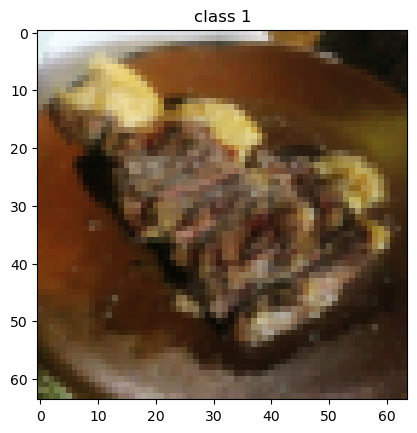

In [145]:
image0, label0= extract_img(next(iter(train_loader)))
plt.imshow(image0)
plt.title(f"class {label0}")

### Mimicking the ImageFolder class

In [81]:
# import os
# import pathlib
# import torch

# from PIL import Image
# from torch.utils.data import DataLoader
# from torchvision import transforms
from typing import Tuple, Dict, List

In [123]:
train_set.class_to_idx, train_set.classes

({'pizza': 0, 'steak': 1, 'sushi': 2}, ['pizza', 'steak', 'sushi'])

In [124]:
target_dir = train_path
print(f"Target directory : {target_dir}")

Target directory : data/pizza_steak_sushi/train


In [125]:
class_names = sorted([dir.name for dir in os.scandir(train_path)])

In [126]:
def find_classes(directory: str) -> Tuple[List[str], Dict[str, int]]:
    """ find the classes in the directory and returns : 
        - the list of the classes names (ordered)
        - the dictionnary of the class to index match
    """

    classes_names = sorted([entry.name for entry in os.scandir(train_path) if entry.is_dir()])
    class_to_idx = {name : idx for (idx, name) in enumerate(classes_names)}

    return classes_names, class_to_idx

In [127]:
find_classes(train_path)

(['pizza', 'steak', 'sushi'], {'pizza': 0, 'steak': 1, 'sushi': 2})

In [128]:
class CustomDataset(Dataset):

    # initilaize the Dataset
    def __init__(self, targ_dir: str, transform=None) -> None:
        # path : get the path of every single image
        self.paths = [image_path for image_path in targ_dir.glob("*/*.jpg")] # to change wif need to have jpg and png. 
        # trick : glob("*/*.jpg") : only looks 1 layer down for pg. glob("**/*.jpg") searches all layers down

        self.transform = transform

        self.classes_names, self.class_to_idx = find_classes(targ_dir)

    # kind of optionnal
    def load_image(self, index: int) -> Image.Image:
        return Image.open(self.paths[index])

    # to overwrite
    def __len__(self) -> int:
        return len(self.paths)

    # compulsory to overwrite
    def __getitem__(self, index: int) -> Tuple[torch.Tensor, int]:
        
        image = self.load_image(index)
        label_name = self.paths[index].parent.stem
        label = self.class_to_idx[label_name]

        # /!\ Apply transform !
        tensor = image if self.transform is None else self.transform(image)

        return tensor, label


# Datasets and dataloaders are built. Let's get to the model

`TrivialAugment()` ?

In [139]:
class TinyVGG(nn.Module):
    """
        see https://poloclub.github.io/cnn-explainer/
    """

    def __init__(self, input_shape: int, hidden_units: int, output_shape: int) -> None:
        super().__init__()
        self.conv_block1 = nn.Sequential(
            nn.Conv2d(input_shape, hidden_units, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(hidden_units, hidden_units, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )

        self.conv_block2 = nn.Sequential(
            nn.Conv2d(hidden_units, hidden_units, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(hidden_units, hidden_units, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )

        self.classifier = nn.Sequential(nn.Flatten(), 
                                        nn.Linear(in_features=hidden_units*16*16, out_features=output_shape))
        
        # to try and improve final classifier
        self.feature_extraction = nn.Sequential(
            self.conv_block1,
            self.conv_block2,
            nn.Flatten()
        )

    
    def forward(self, x):
        features = self.conv_block2(self.conv_block1(x))
        return self.classifier(features)

torch.manual_seed(42)

In [150]:
model_0 = TinyVGG(input_shape=3,
                  hidden_units=10, 
                  output_shape=3).to(device)

model_0

TinyVGG(
  (conv_block1): Sequential(
    (0): Conv2d(3, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv_block2): Sequential(
    (0): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=2560, out_features=3, bias=True)
  )
  (feature_extraction): Sequential(
    (0): Sequential(
      (0): Conv2d(3, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU()
      (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (3): ReLU()
      (4): Ma

In [146]:
from torchinfo import summary

summary(model_0, input_data=next(iter(train_loader))[0])

Layer (type:depth-idx)                   Output Shape              Param #
TinyVGG                                  [16, 3]                   --
├─Sequential: 1-1                        --                        --
│    └─Sequential: 2-1                   [16, 10, 32, 32]          --
│    │    └─Conv2d: 3-1                  [16, 10, 64, 64]          280
│    │    └─ReLU: 3-2                    [16, 10, 64, 64]          --
│    │    └─Conv2d: 3-3                  [16, 10, 64, 64]          910
│    │    └─ReLU: 3-4                    [16, 10, 64, 64]          --
│    │    └─MaxPool2d: 3-5               [16, 10, 32, 32]          --
│    └─Sequential: 2-2                   [16, 10, 16, 16]          --
│    │    └─Conv2d: 3-6                  [16, 10, 32, 32]          910
│    │    └─ReLU: 3-7                    [16, 10, 32, 32]          --
│    │    └─Conv2d: 3-8                  [16, 10, 32, 32]          910
│    │    └─ReLU: 3-9                    [16, 10, 32, 32]          --
│    │    └

In [168]:
image_0, label_0 = extract_img(next(iter(train_loader)), 4)

print(f"Img in-size {image_0.unsqueeze(dim=0).shape}\n")

model_0.eval()
with torch.inference_mode():
    pred= model_0(image_0.unsqueeze(dim=0).to(device))

print(f"logit output: {pred}")
print(f"Proba output: {torch.softmax(pred, dim=1)}")
print(f"Predicted class: {torch.argmax(torch.softmax(pred, dim=1))}")
print(f"Actual label: {label_0}")

Img in-size tensor([[[[0.7529, 0.8353, 0.8431,  ..., 0.4941, 0.4314, 0.3255],
          [0.4980, 0.6392, 0.7294,  ..., 0.5098, 0.5373, 0.3961],
          [0.2392, 0.2431, 0.3451,  ..., 0.5725, 0.6275, 0.6431],
          ...,
          [0.9216, 0.9255, 0.9412,  ..., 0.8275, 0.8784, 0.9686],
          [0.9098, 0.9176, 0.9294,  ..., 0.8431, 0.9255, 0.9922],
          [0.8627, 0.8980, 0.9059,  ..., 0.8588, 0.9725, 0.9961]],

         [[0.6863, 0.7882, 0.7922,  ..., 0.3725, 0.2706, 0.1412],
          [0.3725, 0.5333, 0.6275,  ..., 0.3882, 0.4078, 0.2392],
          [0.1176, 0.1216, 0.2235,  ..., 0.4784, 0.5333, 0.5333],
          ...,
          [0.4824, 0.4863, 0.4941,  ..., 0.4392, 0.6039, 0.8941],
          [0.4706, 0.4980, 0.5294,  ..., 0.5059, 0.7686, 0.9804],
          [0.3647, 0.4392, 0.5059,  ..., 0.6039, 0.9176, 0.9882]],

         [[0.7373, 0.8471, 0.8510,  ..., 0.3255, 0.2118, 0.0745],
          [0.3608, 0.5412, 0.6431,  ..., 0.3294, 0.3529, 0.1686],
          [0.1020, 0.1137, 0.2

In [161]:
train_set[0][0].unsqueeze(dim=0).shape

torch.Size([1, 3, 64, 64])

In [162]:
next(iter(train_loader))[0].unsqueeze(dim=0).shape

torch.Size([1, 16, 3, 64, 64])

In [170]:
try:
    import torchinfo

except:
    !pip install torchinfo
    import torchinfo

from torchinfo import summary

summary(model_0, input_data=next(iter(train_loader))[0].to(device)) # both have to be in the same device in order to work

Layer (type:depth-idx)                   Output Shape              Param #
TinyVGG                                  [16, 3]                   --
├─Sequential: 1-1                        --                        --
│    └─Sequential: 2-1                   [16, 10, 32, 32]          --
│    │    └─Conv2d: 3-1                  [16, 10, 64, 64]          280
│    │    └─ReLU: 3-2                    [16, 10, 64, 64]          --
│    │    └─Conv2d: 3-3                  [16, 10, 64, 64]          910
│    │    └─ReLU: 3-4                    [16, 10, 64, 64]          --
│    │    └─MaxPool2d: 3-5               [16, 10, 32, 32]          --
│    └─Sequential: 2-2                   [16, 10, 16, 16]          --
│    │    └─Conv2d: 3-6                  [16, 10, 32, 32]          910
│    │    └─ReLU: 3-7                    [16, 10, 32, 32]          --
│    │    └─Conv2d: 3-8                  [16, 10, 32, 32]          910
│    │    └─ReLU: 3-9                    [16, 10, 32, 32]          --
│    │    └

In [171]:
def train_epoch(model: nn.Module,
                train_data: DataLoader,
                loss_fn: torch.nn.Module,
                optimizer: torch.optim.Optimizer) -> Tuple[float]:
    """ Training loop for one epoch. Assumes that model is already on device. """

    model.train()
    
    train_loss, train_acc= 0, 0

    for i, (X, y) in enumerate(train_data):
        X, y = X.to(device), y.to(device)
        
        # forward pass
        y_pred = model(X)

        # back propagation
        loss = loss_fn(y_pred, y)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # metrics
        y_pred_class = torch.argmax(torch.softmax(y_pred, dim=1), dim=1)
        acc = (y_pred_class == y).sum().item()/len(y)

        train_loss += loss.item()
        train_acc += acc

    return train_loss/len(train_data), train_acc/len(train_data)


In [181]:
def test_epoch(model: nn.Module,
               test_data: DataLoader,
               loss_fn: nn.Module):
    
    model.eval()
    test_loss=0
    test_acc =0

    for X, y in test_data:
        X, y = X.to(device), y.to(device)
        y_pred=model(X)

        loss = loss_fn(y_pred, y)
        test_loss += loss.item()

        y_classes = torch.argmax(torch.softmax(y_pred, dim=1), dim=1)

        acc = (y== y_classes).sum().item()/len(y)
        test_acc += acc

    return test_loss/len(test_data), test_acc/len(test_data)

        


In [182]:
try:
    import tqdm
except:
    !pip install tqdm
    import tqdm

from tqdm.auto import tqdm

def train(model: nn.Module,
          epochs: int,
          train_dl: DataLoader,
          test_dl: DataLoader,
          optimizer: torch.optim.Optimizer, 
          loss_fn: nn.Module = nn.CrossEntropyLoss()):
    
    model.to(device)

    metrics = {
        "train_loss" : [],
        "train_acc" : [],
        "test_loss" : [],
        "test_acc" : []
    }

    for i in tqdm(range(epochs)):
        train_loss, train_acc = train_epoch(model, train_dl, loss_fn, optimizer)
        metrics["train_loss"].append(train_loss)
        metrics["train_acc"].append(train_acc)

        test_loss, test_acc = test_epoch(model, test_dl, loss_fn)
        metrics["test_loss"].append(test_loss)
        metrics["test_acc"].append(test_acc)

        print(f"Epoch {i+1}: \n \tTrain_loss: {train_loss:.3f} | Train_acc: {train_acc:.3f} \n \t Test_loss: {test_loss:.3f} | Test_acc: {test_acc:.3f}")
    
    return metrics
    
    

In [183]:
torch.manual_seed(42)
NUM_EPOCHS = 10

model_0 = TinyVGG(input_shape=3,
                  hidden_units=10, 
                  output_shape=3)

loss_fn = nn.CrossEntropyLoss()
adam = torch.optim.Adam(params=model_0.parameters(), lr=.001)

In [185]:
metrics = train(model_0, NUM_EPOCHS, train_loader, test_loader, adam, loss_fn)

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 1: 
 	Train_loss: 0.787 | Train_acc: 0.662 
 	 Test_loss: 0.989 | Test_acc: 0.442
Epoch 2: 
 	Train_loss: 0.912 | Train_acc: 0.637 
 	 Test_loss: 1.014 | Test_acc: 0.448
Epoch 3: 
 	Train_loss: 0.955 | Train_acc: 0.487 
 	 Test_loss: 0.973 | Test_acc: 0.480
Epoch 4: 
 	Train_loss: 0.827 | Train_acc: 0.671 
 	 Test_loss: 0.949 | Test_acc: 0.480
Epoch 5: 
 	Train_loss: 0.779 | Train_acc: 0.646 
 	 Test_loss: 1.016 | Test_acc: 0.503
Epoch 6: 
 	Train_loss: 0.706 | Train_acc: 0.704 
 	 Test_loss: 0.991 | Test_acc: 0.435
Epoch 7: 
 	Train_loss: 0.732 | Train_acc: 0.700 
 	 Test_loss: 1.110 | Test_acc: 0.473
Epoch 8: 
 	Train_loss: 0.761 | Train_acc: 0.642 
 	 Test_loss: 1.021 | Test_acc: 0.491
Epoch 9: 
 	Train_loss: 0.734 | Train_acc: 0.679 
 	 Test_loss: 1.019 | Test_acc: 0.503
Epoch 10: 
 	Train_loss: 0.741 | Train_acc: 0.675 
 	 Test_loss: 1.030 | Test_acc: 0.473


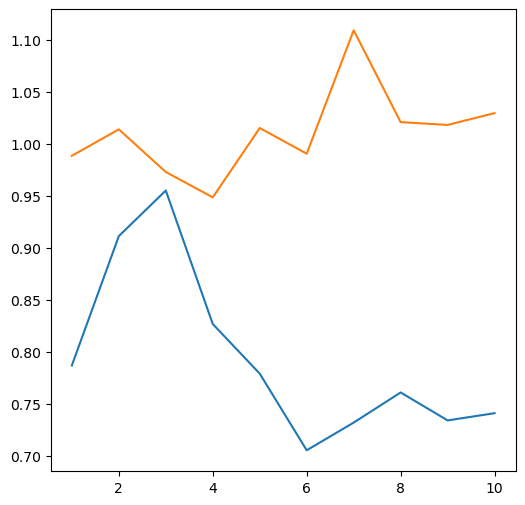

In [190]:
plt.figure(figsize=(6,6))

plt.plot(range(1, NUM_EPOCHS +1), metrics["train_loss"], label = "train_loss")
plt.plot(range(1, NUM_EPOCHS +1), metrics["test_loss"], label= "test_loss")

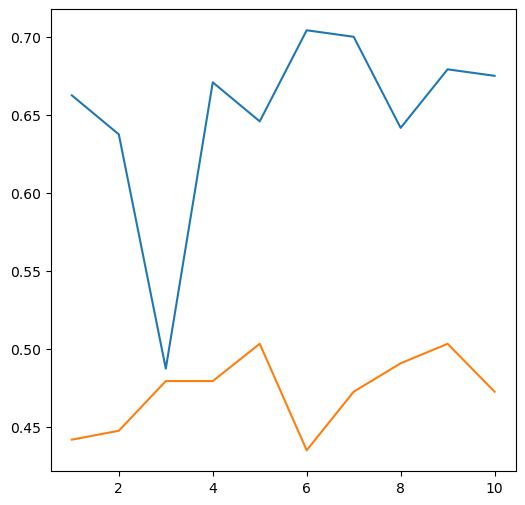

In [191]:
plt.figure(figsize=(6,6))

plt.plot(range(1, NUM_EPOCHS +1), metrics["train_acc"], label = "train_acc")
plt.plot(range(1, NUM_EPOCHS +1), metrics["test_acc"], label= "test_acc")

In [198]:
model_1 = TinyVGG(input_shape=3, hidden_units=10, output_shape=3)
loss_fn_1 = nn.CrossEntropyLoss()
optimizer_1 = torch.optim.Adam(params= model_1.parameters(), lr = 0.002)

In [202]:
torch.manual_seed(42)

NUM_EPOCHS=10

model_1_metrics= train(model_1, 
                       NUM_EPOCHS,
                       train_loader,
                       test_loader,
                       optimizer_1,
                       loss_fn_1
                       )

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 1: 
 	Train_loss: 1.096 | Train_acc: 0.388 
 	 Test_loss: 1.106 | Test_acc: 0.312
Epoch 2: 
 	Train_loss: 1.096 | Train_acc: 0.388 
 	 Test_loss: 1.106 | Test_acc: 0.312
Epoch 3: 
 	Train_loss: 1.095 | Train_acc: 0.388 
 	 Test_loss: 1.108 | Test_acc: 0.312
Epoch 4: 
 	Train_loss: 1.091 | Train_acc: 0.400 
 	 Test_loss: 1.118 | Test_acc: 0.375
Epoch 5: 
 	Train_loss: 1.082 | Train_acc: 0.442 
 	 Test_loss: 1.060 | Test_acc: 0.409
Epoch 6: 
 	Train_loss: 1.030 | Train_acc: 0.483 
 	 Test_loss: 1.104 | Test_acc: 0.398
Epoch 7: 
 	Train_loss: 1.082 | Train_acc: 0.383 
 	 Test_loss: 1.071 | Test_acc: 0.366
Epoch 8: 
 	Train_loss: 1.049 | Train_acc: 0.471 
 	 Test_loss: 1.053 | Test_acc: 0.366
Epoch 9: 
 	Train_loss: 1.035 | Train_acc: 0.450 
 	 Test_loss: 1.066 | Test_acc: 0.392
Epoch 10: 
 	Train_loss: 1.037 | Train_acc: 0.542 
 	 Test_loss: 1.063 | Test_acc: 0.436


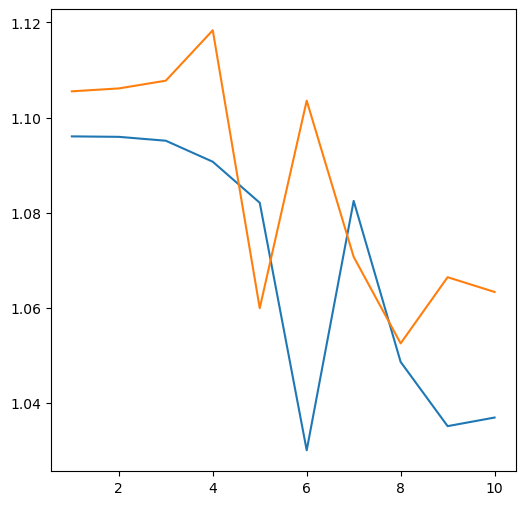

In [203]:
plt.figure(figsize=(6,6))

plt.plot(range(1, NUM_EPOCHS +1), model_1_metrics["train_loss"], label = "train_loss")
plt.plot(range(1, NUM_EPOCHS +1), model_1_metrics["test_loss"], label= "test_loss")